## Behavioural Cloning 
This notebook includes Data visualization for the Udacity Self-Driving Car Program's Behavioual Cloning project.

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
import imageio
import cv2

In [9]:
# INPUT DATA
drive_dirs = ['run1','run2','run4','run5','run7','run8']
# drive_dirs = ['run8']
drive_data = []

for datadir in drive_dirs:
    training_data_directory = './BCdata/'+datadir+'/'
    training_data_filename = 'driving_log.csv'
    training_datafile = training_data_directory+training_data_filename

    # Import data
    with open(training_datafile) as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            # Fix File Paths
            for img_num in range(3):
                line[img_num] = training_data_directory+'/'.join(line[img_num].split('/')[-2:])
            drive_data.append(line)


In [10]:
print(drive_data[-1])

['./BCdata/run8/IMG/center_2018_09_09_17_50_44_439.jpg', './BCdata/run8/IMG/left_2018_09_09_17_50_44_439.jpg', './BCdata/run8/IMG/right_2018_09_09_17_50_44_439.jpg', '0.1037736', '0', '0', '6.573231']


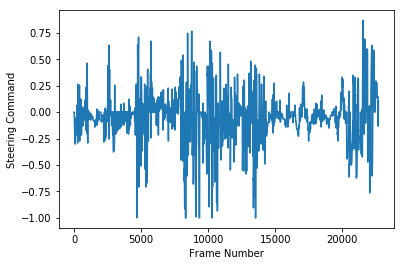

In [11]:
# Visualize Steering Signal Range
steering_data = np.array([float(row[3]) for row in drive_data[1:]])
plt.plot(steering_data)
plt.xlabel('Frame Number')
plt.ylabel('Steering Command')

In [12]:
# Augment Training Data with Left and Right images
image_data = []
steering_data = []

# Left/Right augmentation Correction
deg_correct = 0.3

for row in drive_data:
    for chan in range(3):
        image_data.append(row[chan])
        if chan == 0: # Center
            steering_data.append(float(row[3]))
        elif chan == 1: # Left
            steering_data.append(float(row[3]) + deg_correct)
        elif chan == 2: # Right
            steering_data.append(float(row[3]) - deg_correct)


Data: ['./BCdata/run4/IMG/center_2018_09_09_02_52_55_798.jpg', './BCdata/run4/IMG/left_2018_09_09_02_52_55_798.jpg', './BCdata/run4/IMG/right_2018_09_09_02_52_55_798.jpg', '-0.7075471', '0', '0', '6.229488']
Paths: ./BCdata/run4/IMG/left_2018_09_09_02_52_55_798.jpg ./BCdata/run4/IMG/center_2018_09_09_02_52_55_798.jpg ./BCdata/run4/IMG/right_2018_09_09_02_52_55_798.jpg
Image Size:  (90, 320, 3)
['-0.7075471', '0', '0', '6.229488']


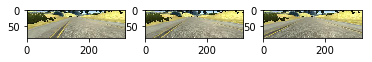

In [24]:
# Visualize Training Data
iData = np.random.randint(len(drive_data))

# Data row
datarows = drive_data[iData]
print('Data:', datarows)

center_image_path = datarows[0]
left_image_path = datarows[1]
right_image_path = datarows[2]

print('Paths:',left_image_path,center_image_path, right_image_path)

# import file
center_image = imageio.imread(center_image_path)
left_image = imageio.imread(left_image_path)
right_image = imageio.imread(right_image_path)

# Image Dimensions
image_size = center_image.shape
print('Image Size: ',image_size)

# Show cropping
center_image = center_image[40:-30,:]
left_image = left_image[40:-30,:]
right_image = right_image[40:-30,:]

plt.subplot(1,3,1)
plt.imshow(left_image)
plt.subplot(1,3,2)
plt.imshow(center_image)
plt.subplot(1,3,3)
plt.imshow(right_image)

# Measurement Data
print(datarows[3:])

steering_measurement = datarows[3]

In [25]:
# Count Data     
Ndata = len(image_data)

# Train, Validation, Test
val_pct = 0.2

# Split Data into Train, Validation and Test
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(image_data, steering_data, test_size = val_pct, random_state = 54)

# Data Sizes
Ntrain = len(X_train)
Nval = len(X_val)
assert(Ntrain == len(y_train))

print('-- TRAINING DATA --')
print(('\tSize of Training Set: %d')%(Ntrain))
print('-- VALIDATION DATA --')
print(('\tSize of Training Set: %d')%(Nval))

-- TRAINING DATA --
	Size of Training Set: 54441
-- VALIDATION DATA --
	Size of Training Set: 13611


Data: ./BCdata/run4/IMG/center_2018_09_09_02_52_55_798.jpg  Steering: -0.23396225999999998


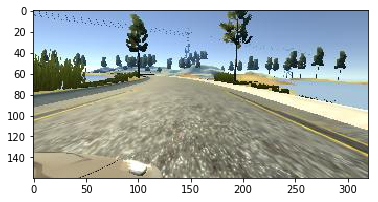

In [26]:
# Test Directory read for new data
iData = np.random.randint(len(X_train))

# Data row
image_path = X_train[iData]
steering = y_train[iData]
print('Data:', center_image_path, ' Steering:', steering)

# import file
train_image = imageio.imread(image_path)
plt.imshow(train_image)

In [27]:
# Data generator for the Center Camera Channel
import sklearn
def centerCameraBatch(X_data, y_data, batchsize = 128, flip_batch = True):
    # Batch Data Generator for Nbatch
    Ndata = len(X_data)
    if flip_batch:
        Nbatch = int(np.ceil(Ndata/(batchsize/2)))
    else:
        Nbatch = int(np.ceil(Ndata/batchsize))
    while 1:
        # Measurements
        for ibatch in range(Nbatch):
            X = []
            y = []
            if flip_batch:
                 batch_index = (int(ibatch*(batchsize/2)),\
                                np.minimum(Ndata,int((ibatch+1)*(batchsize/2))))
            else:
                 batch_index = (ibatch*batchsize,\
                                np.minimum(Ndata,(ibatch+1)*batchsize))
            
            # Get samples
            for idx in np.arange(batch_index[0],batch_index[1]):
                image_file = X_data[idx]
                image = imageio.imread(image_file)
                
                X.append(image)
                y.append(y_data[idx])
                                
                if flip_batch:
                    # Flip Image left->right.
                    # Invert Steering
                    X.append(cv2.flip(image,1))
                    y.append(-y_data[idx])
            yield sklearn.utils.shuffle(np.array(X), np.array(y))

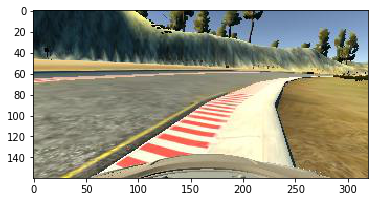

12


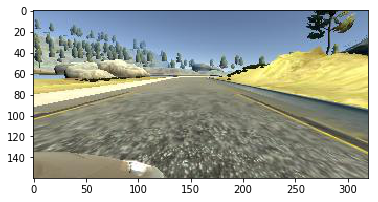

12


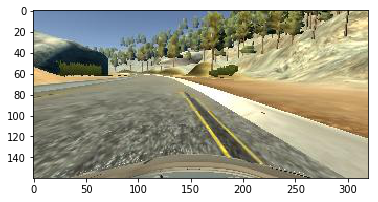

12


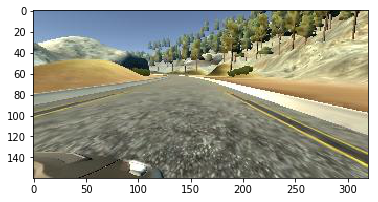

6


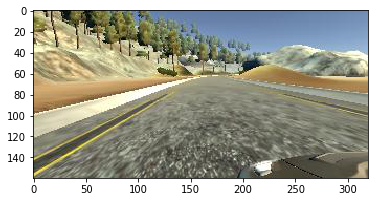

12
Data Shape: (12, 160, 320, 3)
Label Shape: (12,)


In [28]:
# Test Data Generator
batch_size = 12
Ntest = 21

datagen = centerCameraBatch(X_train[:Ntest],y_train[:Ntest],batch_size)
ii = 0
for ibatch in range(5):
    X_batch, y_batch = next(datagen)
    plt.imshow(X_batch[-1])
    plt.show()
    ii += 1
    print(len(X_batch))
    
# Data Generator
print('Data Shape:', X_batch.shape)
print('Label Shape:', y_batch.shape)

In [40]:
# Experiment loading a Pre-trained Model
from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Sequential, Model
from keras.layers import Lambda, Cropping2D


import numpy as np

# Image Pre-processing
# set up lambda layer
pre_model = Sequential()
pre_model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))
pre_model.add(Cropping2D(cropping=((40,30), (0,0)), input_shape=(160,320,3)))
print(pre_model.output_shape)

(None, 90, 320, 3)


In [41]:
base_model = VGG19(weights='imagenet',\
                   include_top=False,\
                   input_shape=pre_model.output_shape[1:],\
                   input_tensor=pre_model.output)
# base_model = InceptionV3(include_top=False, weights='imagenet',\
#                           input_shape=image_size)
print(base_model)

In [42]:
for layer in base_model.layers:
    print(layer.name, layer.input_shape, layer.output_shape)
    
# Model Checking
Num_BASE_layers = len(base_model.layers)
print('Base Model Layers:', Num_BASE_layers)

lambda_6_input (None, 160, 320, 3) (None, 160, 320, 3)
lambda_6 (None, 160, 320, 3) (None, 160, 320, 3)
cropping2d_6 (None, 160, 320, 3) (None, 90, 320, 3)
block1_conv1 (None, 90, 320, 3) (None, 90, 320, 64)
block1_conv2 (None, 90, 320, 64) (None, 90, 320, 64)
block1_pool (None, 90, 320, 64) (None, 45, 160, 64)
block2_conv1 (None, 45, 160, 64) (None, 45, 160, 128)
block2_conv2 (None, 45, 160, 128) (None, 45, 160, 128)
block2_pool (None, 45, 160, 128) (None, 22, 80, 128)
block3_conv1 (None, 22, 80, 128) (None, 22, 80, 256)
block3_conv2 (None, 22, 80, 256) (None, 22, 80, 256)
block3_conv3 (None, 22, 80, 256) (None, 22, 80, 256)
block3_conv4 (None, 22, 80, 256) (None, 22, 80, 256)
block3_pool (None, 22, 80, 256) (None, 11, 40, 256)
block4_conv1 (None, 11, 40, 256) (None, 11, 40, 512)
block4_conv2 (None, 11, 40, 512) (None, 11, 40, 512)
block4_conv3 (None, 11, 40, 512) (None, 11, 40, 512)
block4_conv4 (None, 11, 40, 512) (None, 11, 40, 512)
block4_pool (None, 11, 40, 512) (None, 5, 20, 512

In [43]:
from keras.layers import Dense, GlobalAveragePooling2D, Conv2D, Flatten

# Output Network (2 Dense Layers)
out_network_input = base_model.output_shape
print('Input Network Shape:', out_network_input)

outut_variables = 1;
output_network_filters = 256
x = Conv2D(output_network_filters,(1,1), activation='relu')(base_model.output)
x = GlobalAveragePooling2D()(x)

# Fully-connected Dense layer
x = Dense(128, activation='relu')(x)

# Linear Prediction layer
predictions = Dense(outut_variables, activation='linear')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# Train only the output layers (which were randomly initialized)
# i.e. freeze all convolutional VGG19 layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='mean_squared_error')

# train the model on the new data for a few epochs
EPOCHS = 10
N_batch = 64
Ntrain_per_epoch = np.ceil(Ntrain/N_batch)
Nval_per_epoch = np.ceil(Nval/N_batch)


training_generator = centerCameraBatch(X_train, y_train, N_batch, flip_batch=True)
validation_generator = centerCameraBatch(X_val, y_val, N_batch, flip_batch=False)


Input Network Shape: (None, 2, 10, 512)


In [46]:
# Add Checkpoint
from keras.callbacks import ModelCheckpoint
modelcheckpointer = ModelCheckpoint('model.h5',\
                                    monitor='val_loss',\
                                    verbose=1,\
                                    save_best_only=True)


In [ ]:
# Fit Model
model.fit_generator(training_generator,\
                    steps_per_epoch = Ntrain_per_epoch,\
                    epochs = EPOCHS,\
                    validation_data = validation_generator,\
                    validation_steps = Nval_per_epoch,\
                    callbacks = [modelcheckpointer],\
                    verbose = 1)

Epoch 1/10
851/851 [==============================] - 1593s 2s/step - loss: 0.0934 - val_loss: 0.0607
Epoch 2/10
851/851 [==============================] - 1586s 2s/step - loss: 0.0586 - val_loss: 0.0509
Epoch 3/10
851/851 [==============================] - 1582s 2s/step - loss: 0.0513 - val_loss: 0.0447
Epoch 4/10
851/851 [==============================] - 1582s 2s/step - loss: 0.0453 - val_loss: 0.0457
Epoch 5/10
851/851 [==============================] - 1584s 2s/step - loss: 0.0426 - val_loss: 0.0409
Epoch 6/10
  1/851 [..............................] - ETA: 21:03 - loss: 0.0811

In [ ]:
#Save Model to Disk
model.save('model.h5')